In [4]:
# Packages
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
import seaborn as sns
#가설검정 및 통계분석
from scipy import stats
from statsmodels.formula.api import ols
#선형모델 formula
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.anova import anova_lm
import scipy.stats
from scipy.stats import chi2_contingency 
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
#qqplot, 상수항 추가
from statsmodels.api import qqplot, add_constant
#선형모델 formula
import statsmodels.formula.api as smf
from statsmodels.stats.stattools import omni_normtest


# warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

matplotlib.rc("font",family='NanumGothic')
matplotlib.rcParams['axes.unicode_minus']=False

### 다중회귀분석_규제화 실습
아래는 당뇨병 발병 원인과 관련된 데이터이다. 당뇨병 발생을 예측하기 위해 규제화 회귀분석을
실시하고 결과를 해석하시오.

In [5]:
data = pd.read_csv('./DATA/DIABETES.csv', encoding='euc-kr')
data.head()

,Y,AGE,GENDER,BMI,BP,CHOLESTEROL,LDL,HDL,TCH,LTG,GLUCOSE
0,151,59,2,32.1,101.0,157,93.2,38.0,4.0,4.8598,87
1,75,48,1,21.6,87.0,183,103.2,70.0,3.0,3.8918,69
2,141,72,2,30.5,93.0,156,93.6,41.0,4.0,4.6728,85
3,206,24,1,25.3,84.0,198,131.4,40.0,5.0,4.8903,89
4,135,50,1,23.0,101.0,192,125.4,52.0,4.0,4.2905,80


findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


<Figure size 1080x720 with 0 Axes>

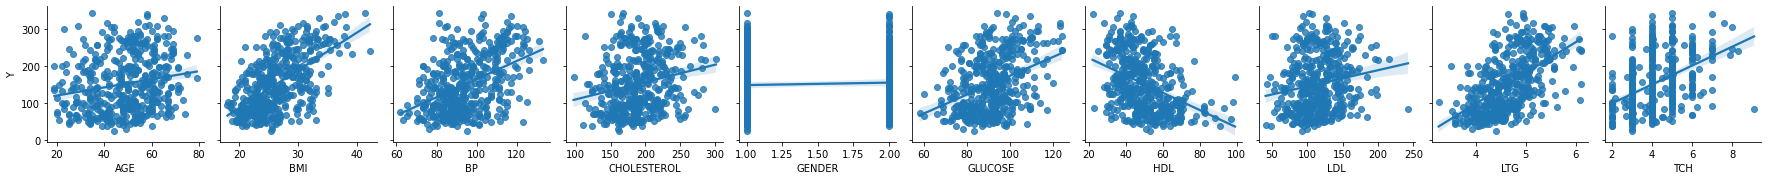

<Figure size 1080x720 with 0 Axes>

In [6]:
# 산점도 행렬, 회귀 적합선 추가

sns.pairplot(data, y_vars="Y", x_vars=data.columns.difference(['Y']), kind='reg')

plt.figure(figsize=(15,10))

목표변수에 대한 산점도 출력 결과, BMI, BP, HDL, GLUCOSE, LTG에서 선형관계가 있음을 확인할 수 있다.

In [7]:
data.corr().round(3)

,Y,AGE,GENDER,BMI,BP,CHOLESTEROL,LDL,HDL,TCH,LTG,GLUCOSE
Y,1.000,0.188,0.043,0.586,0.441,0.212,0.174,-0.395,0.430,0.566,0.382
AGE,0.188,1.000,0.174,0.185,0.335,0.260,0.219,-0.075,0.204,0.271,0.302
GENDER,0.043,0.174,1.000,0.088,0.241,0.035,0.143,-0.379,0.332,0.150,0.208
BMI,0.586,0.185,0.088,1.000,0.395,0.250,0.261,-0.367,0.414,0.446,0.389
BP,0.441,0.335,0.241,0.395,1.000,0.242,0.186,-0.179,0.258,0.393,0.390
CHOLESTEROL,0.212,0.260,0.035,0.250,0.242,1.000,0.897,0.052,0.542,0.516,0.326
LDL,0.174,0.219,0.143,0.261,0.186,0.897,1.000,-0.196,0.660,0.318,0.291
HDL,-0.395,-0.075,-0.379,-0.367,-0.179,0.052,-0.196,1.000,-0.738,-0.399,-0.274
TCH,0.430,0.204,0.332,0.414,0.258,0.542,0.660,-0.738,1.000,0.618,0.417
LTG,0.566,0.271,0.150,0.446,0.393,0.516,0.318,-0.399,0.618,1.000,0.465


전체 데이터셋에 대한 상관관계를 출력한 결과, 목표변수를 제외한 변수들 간에 일부 선형관계가 확인된다. CHOLESTEROL과 LDL의 상관관계는 0.897로 매우 높으며, TCH와 HDL은 -0.738로 높은 음의 상관관계를 보이고 있다. 이는 다중공선성이 존재할 확률이 높으므로, 이에 대한 처리가 필요하다고 판단된다.

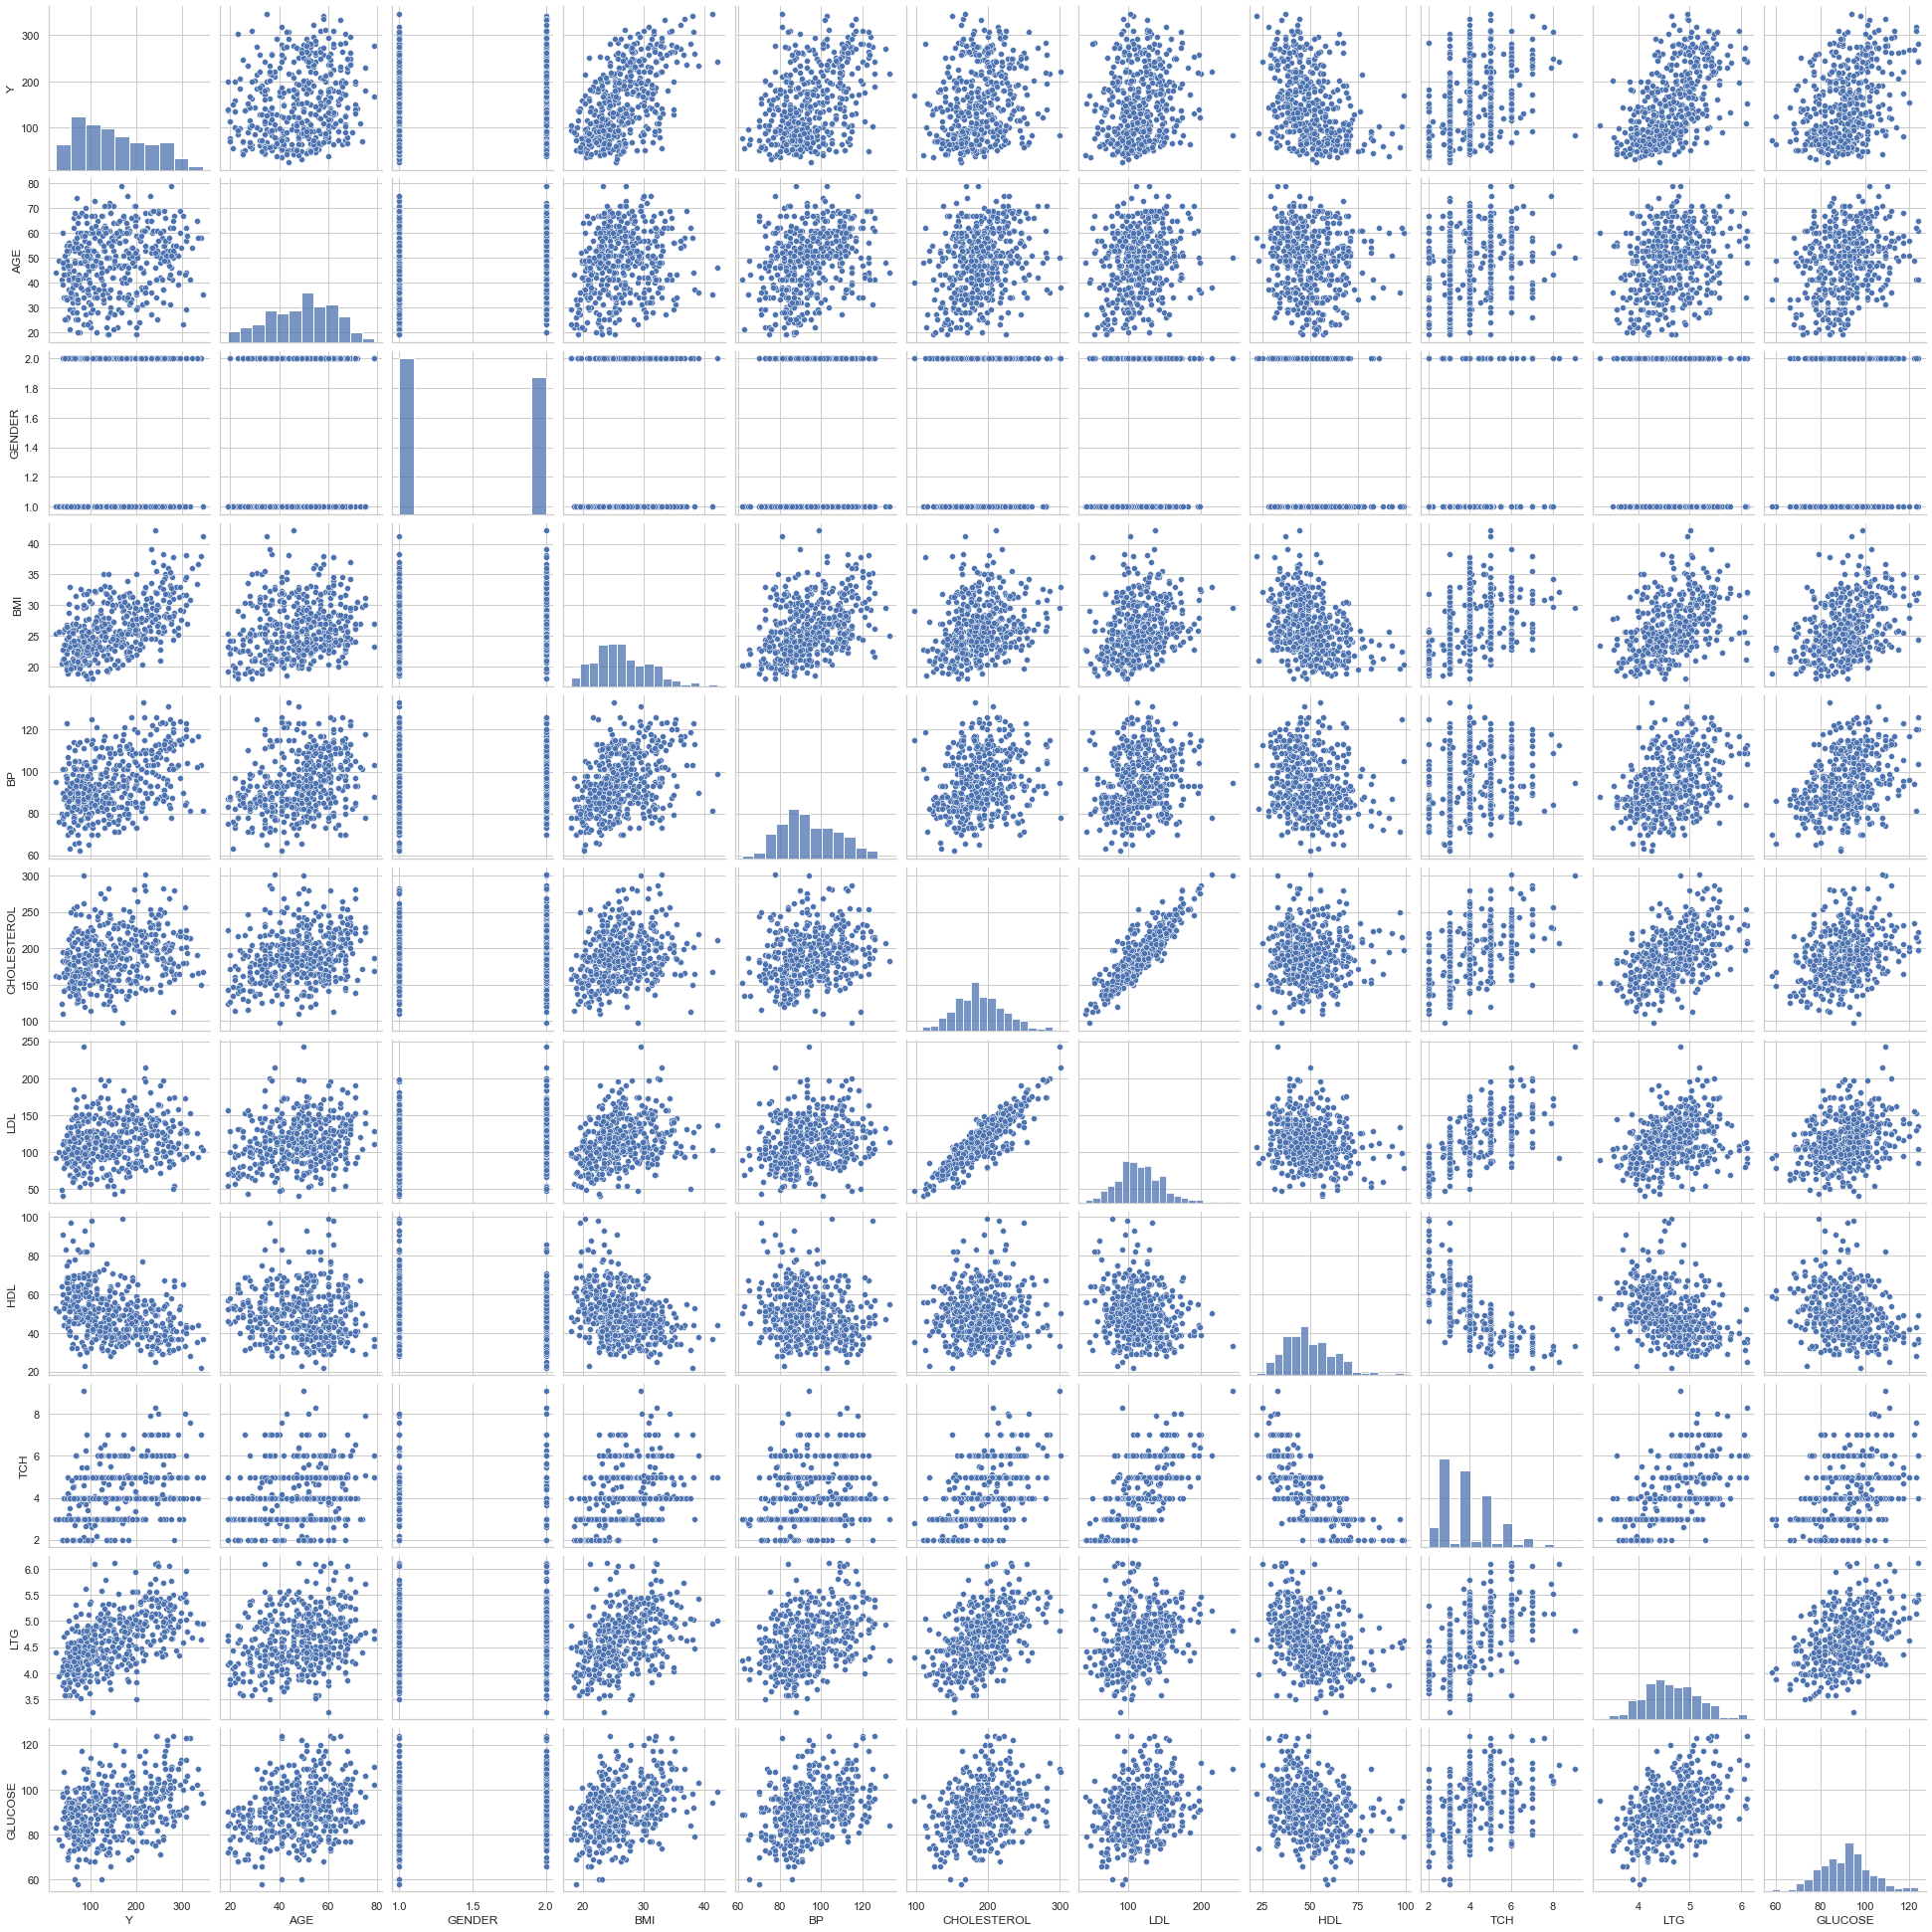

In [9]:
sns.set(style = 'whitegrid', context = 'notebook')
sns.pairplot(data, height = 2.5)
plt.show()
# 당뇨수치(Y)의 경우 BMI, BP, HDL, LTG, GLUCOSE와 선형관계가 있음
# AGE, BMI 또한 BP, HDL, LTG, GLUCOSE와 선형관계 있음을 알 수 있음
# 콜레스테롤 수치와 LDL은 강한 양의 선형관계가 있음

In [10]:
# 회귀분석
from statsmodels.formula.api import ols
# qqplot, 회귀분석의 상수항 추가
from statsmodels.api import qqplot, add_constant
# 선형 모델 formula(y ~ X1 + X2 + ...)
import statsmodels.formula.api as smf
# 다중공선성 확인
from statsmodels.stats.outliers_influence import variance_inflation_factor
# 선형회귀모형
from sklearn.linear_model import LinearRegression
# 변수 선택법(후진제거법)
from sklearn.feature_selection import RFE
# Scale 변환->표준화 회귀계수 산출
from sklearn.preprocessing import StandardScaler
# 평가함수
from statsmodels.tools.eval_measures import rmse

In [11]:
reg_model = smf.ols('Y ~ AGE + C(GENDER) + BMI + BP + CHOLESTEROL + LDL + HDL + TCH + LTG + GLUCOSE', data=data)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     46.27
Date:                Mon, 20 Nov 2023   Prob (F-statistic):           3.83e-62
Time:                        11:23:45   Log-Likelihood:                -2386.0
No. Observations:                 442   AIC:                             4794.
Df Residuals:                     431   BIC:                             4839.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       -357.4268     67.058     -5.

전체 변수에 대한 회귀모델 생성 결과이다.
우선 해당 모델에 대한 유의성 검정인 F검정의 p-value 값이 거의 0에 가까운 것으로 보아 해당 모델은 회귀모델로서 유의하다고 볼 수 있다.
수정결정계수( Adj. R-squared )는 0.507로 이 모델을 통하여 설명변수를 50.7% 정도 설명할 수 있으며, 모델 성능은 다소 낮다.
Prob(Omnibus)값이 0.471로 유의수준을 0.05라고 보았을 때 잔차의 정규성 역시 만족되는 것으로 보인다. Durbin-Watson 값이 2.029이므로 잔차의 독립성도 만족한다. 앞서 설명변수들 간의 다중공선성이 확인되므로 이를 제거 후, 다시 모델링을 수행한다.

* Durbin-Watson : 값이 2에 가까우면 오차들은 독립 / DW 값이 0에 가까우면 양의 자기상관 O /값이 4에 가까우면 음의 자기상관 O

In [13]:
# 다중공선성 확인
data_x = data.drop("Y", axis = 1)
data_x_const = add_constant(data_x) 

data_vif = pd.DataFrame()
data_vif["variable"] = data_x_const.columns
data_vif["VIF"] = [variance_inflation_factor(data_x_const.values, i) for i in range(data_x_const.shape[1])]
data_vif.sort_values("VIF", inplace = True)
data_vif.round(3)

,variable,VIF
1,AGE,1.217
2,GENDER,1.278
4,BP,1.459
10,GLUCOSE,1.485
3,BMI,1.509
8,TCH,8.891
9,LTG,10.076
7,HDL,15.402
6,LDL,39.193
5,CHOLESTEROL,59.203


CHOLESTEROL, LDL, HDL, LTG의 경우 VIF가 10 이상으로 다중공선성이 높은 것으로 판단된다.  
따라서, VIF가 가장 높은 CHOLESTEROL을 먼저 제거한다.

In [14]:
# 다중공선성 큰 변수 제거
data_x = data_x.drop("CHOLESTEROL", axis = 1)
data_x_const = add_constant(data_x) 

data_vif = pd.DataFrame()
data_vif["variable"] = data_x_const.columns
data_vif["VIF"] = [variance_inflation_factor(data_x_const.values, i) for i in range(data_x_const.shape[1])]

data_vif.sort_values("VIF", inplace = True)
data_vif.round(3)

,variable,VIF
1,AGE,1.217
2,GENDER,1.275
4,BP,1.457
9,GLUCOSE,1.484
3,BMI,1.502
8,LTG,2.173
5,LDL,2.927
6,HDL,3.737
7,TCH,7.819
0,const,216.005


CHOLESTEROL 제거 후 VIF 출력 결과, 모든 변수가 10 이하로 나타났다. 해당 변수들에 대한 회귀모델을 생성해보자.

In [15]:
reg_model = smf.ols('Y ~ AGE + C(GENDER) + BMI + BP + LDL + HDL + TCH + LTG + GLUCOSE', data=data)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.514
Model:                            OLS   Adj. R-squared:                  0.504
Method:                 Least Squares   F-statistic:                     50.71
Date:                Mon, 20 Nov 2023   Prob (F-statistic):           3.06e-62
Time:                        11:26:09   Log-Likelihood:                -2387.8
No. Observations:                 442   AIC:                             4796.
Df Residuals:                     432   BIC:                             4837.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       -250.7464     36.827     -6.

설명변수 중 CHOLESTEROL을 제거한 모델의 수정 결정계수인 Adj. R-squared 값은 0.504로 앞선 전체 설명변수에 대한 값인 0.518과 거의 차이가 없다. AGE, LDL, TCH, GLUCOSE의 경우 p-value 값이 0.05 이상으로 모델에서 유의하다고 볼 수 없다. 해당 변수들을 제외하고 다시 모델을 생성해보자.

In [17]:
reg_model = smf.ols('Y ~ C(GENDER) + BMI + BP + HDL + LTG', data=data)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.509
Model:                            OLS   Adj. R-squared:                  0.503
Method:                 Least Squares   F-statistic:                     90.26
Date:                Mon, 20 Nov 2023   Prob (F-statistic):           4.75e-65
Time:                        12:19:41   Log-Likelihood:                -2390.1
No. Observations:                 442   AIC:                             4792.
Df Residuals:                     436   BIC:                             4817.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       -240.1591     34.316     -6.

모델링 결과 수정 결정계수는 0.503으로, 앞선 모델과 거의 유사한 설명력을 보인다. 위 모델에서는 각 변수들의 p-value 값이 모두 0.05 이하로 회귀계수값이 유의하다고 할 수 있다.  

다음은 후진제거법, 순차 특성 선택 모델을 각각 생성해 보았다.

In [16]:
# RFE 함수를 통해 변수중요도가 낮은 순으로 순차적 변수 제거
data_y = data['Y']
model = LinearRegression()
rfe = RFE(estimator = model, n_features_to_select=5).fit(data_x, data_y)
selected_cols = data_x.columns[rfe.support_]
removed_cols = data_x.columns[~rfe.support_]

print('선택된 변수 :', selected_cols) # 선택된 변수
print('제거된 변수 :', removed_cols) # 제거된 변수

선택된 변수 : Index(['GENDER', 'BMI', 'HDL', 'TCH', 'LTG'], dtype='object')
제거된 변수 : Index(['AGE', 'BP', 'LDL', 'GLUCOSE'], dtype='object')


In [18]:
rfe_reg_model = smf.ols(formula = 'Y ~ C(GENDER) + BMI + HDL + TCH + LTG', data=data)
rfe_reg_result = rfe_reg_model.fit()
print(rfe_reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.480
Model:                            OLS   Adj. R-squared:                  0.474
Method:                 Least Squares   F-statistic:                     80.55
Date:                Mon, 20 Nov 2023   Prob (F-statistic):           9.30e-60
Time:                        12:51:41   Log-Likelihood:                -2402.6
No. Observations:                 442   AIC:                             4817.
Df Residuals:                     436   BIC:                             4842.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       -201.0369     35.674     -5.

후진제거법을 통해 선택된 변수로는 'GENDER', 'BMI', 'HDL', 'TCH', 'LTG'가 있다. 선택된 변수에 대해 모델링 수행 결과, 수정 결정계수는 0.474로, 이전 모델 대비 다소 낮은 설명력임을 알 수 있다. 

In [24]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs # 순차 특성 선택 모델

sfs = sfs(LinearRegression(),
           k_features = 'best', # number of features to select, 'best'도 가능
           forward    = True, # False = backward
           floating   = False, # adds a conditional exclusion/inclusion if Ture
           scoring    = 'r2', # 'accuracy for sklearn classifiers
                          # 'r2' for sklearn regressors
           cv         = 5).fit(data_x, data_y) # cv = cross validation, default = 5

sfs.k_feature_names_

('GENDER', 'BMI', 'BP', 'HDL', 'TCH', 'LTG')

In [26]:
sfs_model = smf.ols(formula = 'Y ~ C(GENDER) + BMI + BP + HDL + TCH + LTG', data=data)
sfs_model_result = sfs_model.fit()
print(sfs_model_result.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.510
Model:                            OLS   Adj. R-squared:                  0.503
Method:                 Least Squares   F-statistic:                     75.41
Date:                Mon, 20 Nov 2023   Prob (F-statistic):           2.80e-64
Time:                        12:59:52   Log-Likelihood:                -2389.6
No. Observations:                 442   AIC:                             4793.
Df Residuals:                     435   BIC:                             4822.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       -232.0189     35.203     -6.

전진제거법을 통해 선택된 변수는 'GENDER', 'BMI', 'BP', 'HDL', 'TCH', 'LTG'이며, 해당 변수들에 대한 모델의 수정 결정계수는 0.503이다. 후진제거법, 전진제거법 모두 이전 모델에 비해 낮거나 비슷한 설명력을 보인다. 이에 유의한 변수들로만 생성된 p-value 기준 모델을 채택한다. 마지막으로 해당 모델의 설명 변수 중요도를 살펴본다.

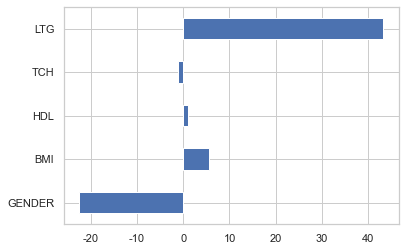

In [31]:
data_reg_coef = pd.DataFrame({'Coef':reg_result.params.values[1:]}, index = selected_cols)
data_reg_coef.plot.barh(y='Coef', legend=False)

결론 :  목표변수 당뇨수치와 설명변수들 간의 회귀분석을 진행해본 결과, 각각의 회귀계수에 대한 p-value 값으로 판단한 모델을 선정했다. 해당 모델을 사용했을 때 Y에 대한 설명변수는 LTG, TCH, HDL, BMI, GENDER 총 5개이며 이 중에서 LTG 값이 가장 변수 중요도가 높은 것을 볼 수 있다.

최종 모델의 회귀식 : y = -232.0189 + -21.8237 C(GENDER) + 5.6939 BMI + 1.1149 BP -1.2637 HDL -3.6388 TCH + 46.6232 LTG